In [35]:
import pandas as pd
import pytz
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import re

In [37]:
# Load Bitcoin data
def transform_bitcoin_data(data: pd.DataFrame) -> pd.DataFrame:
    data['%PriceChange'] = round(((data['Close'] - data['Open']) / data['Open']) * 100, 3)
    data['priceDiff'] = round(data['Close'] - data['Open'], 3)
    data['normalizedVol'] = data['Volume'] / data['Volume'].max()
    data['7DayMovingAvgPrice'] = round(data['Close'].rolling(window=7).mean(), 3)
    data['30DayMovingAvgPrice'] = round(data['Close'].rolling(window=30).mean(), 3)
    data['7DayMovingAvgVol'] = data['normalizedVol'].rolling(window=7).mean()
    data['30DayMovingAvgVol'] = data['normalizedVol'].rolling(window=30).mean()
    return data

def get_bitcoin_data(filename: str) -> pd.DataFrame:
    df = pd.read_csv(filename)
    df['Date'] = pd.to_datetime(df['Date'])
    df = transform_bitcoin_data(df)
    return df

# Load US Law data
def get_US_law_data(filename: str) -> pd.DataFrame:
    df = pd.read_csv(filename)
    df['Date of Introduction'] = pd.to_datetime(df['Date of Introduction'])
    df['Latest Action Date'] = pd.to_datetime(df['Latest Action Date'])
    
    # Check if 'Date of Introduction' already has a timezone
    if df['Date of Introduction'].dt.tz is None:
        df['Date of Introduction'] = df['Date of Introduction'].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
    else:
        df['Date of Introduction'] = df['Date of Introduction'].dt.tz_convert('US/Eastern')
    
    return df

### Method: OLS Regression Model Analysis

The Ordinary Least Squares (OLS) Regression model is a statistical method used to estimate the relationships between a dependent variable and one or more independent variables (regulatory factors like whether the regulation has passed the House, time to next action, and specific regulatory topics).

Regulatory factors: whether the regulation passed(introduced/passed house), date to next action, and type of regulation

Dependent variable: volatility

In [31]:
import pandas as pd
import numpy as np
import re

# Functions

def transform_bitcoin_data(data: pd.DataFrame, window: int = 30) -> pd.DataFrame:
    """
    Calculate Bitcoin volatility (based on log returns standard deviation).

    Args:
        data (pd.DataFrame): DataFrame containing at least a 'Close' column with daily close prices.
        window (int): Rolling window size for volatility calculation. Default is 30 days.

    Returns:
        pd.DataFrame: DataFrame with added 'Log_Return' and 'Volatility' columns.

    >>> df = pd.DataFrame({'Close': [100, 102, 101, 104]})
    >>> result = transform_bitcoin_data(df, window=2)
    >>> round(result['Log_Return'][1], 4)
    0.0198
    >>> round(result['Volatility'][3], 4)  # Example for rolling window volatility
    0.0725
    """
    data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))
    data['Volatility'] = data['Log_Return'].rolling(window=window).std() * np.sqrt(252)  # Annualized volatility
    return data

def get_bitcoin_data(filename: str) -> pd.DataFrame:
    """
    Load Bitcoin data from a CSV file, preprocess it, and calculate volatility.

    Args:
        filename (str): Path to the CSV file containing Bitcoin data with a 'Close' column and 'Date' column.

    Returns:
        pd.DataFrame: Processed DataFrame with 'Log_Return' and 'Volatility' columns.

    Note:
        Doctests are omitted because this function involves file I/O.
    """
    df = pd.read_csv(filename)
    df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None) 
    df = transform_bitcoin_data(df)
    return df

def extract_latest_action_date(df: pd.DataFrame) -> pd.Series:
    """
    Extract the latest date from Related Bill Latest Action columns.

    Args:
        df (pd.DataFrame): DataFrame containing columns with 'Related Bill Latest Action' in their names.

    Returns:
        pd.Series: Series of the latest dates extracted from the related columns.

    >>> df = pd.DataFrame({
    ...     'Related Bill Latest Action 1': ['12/01/2023', None],
    ...     'Related Bill Latest Action 2': [None, '11/30/2023']
    ... })
    >>> result = extract_latest_action_date(df)
    >>> result[0]
    Timestamp('2023-12-01 00:00:00')
    >>> result[1]
    Timestamp('2023-11-30 00:00:00')
    """
    related_cols = [col for col in df.columns if 'Related Bill Latest Action' in col]
    latest_dates = []

    for _, row in df[related_cols].iterrows():
        dates = []
        for value in row.dropna():
            match = re.search(r'(\d{2}/\d{2}/\d{4})', str(value))
            if match:
                dates.append(pd.to_datetime(match.group(1), errors='coerce'))
        latest_dates.append(max(dates) if dates else pd.NaT)

    return pd.Series(latest_dates)

def get_US_law_data(filename: str) -> pd.DataFrame:
    """
    Load and preprocess US law data from a CSV file.

    Args:
        filename (str): Path to the CSV file containing legislative data.

    Returns:
        pd.DataFrame: Processed DataFrame with relevant columns for analysis.

    >>> df = pd.DataFrame({
    ...     'Legislation Number': ['HR 1234', 'S 5678'],
    ...     'Date of Introduction': ['01/01/2023', '02/15/2023'],
    ...     'Related Bill Latest Action 1': ['01/20/2023', None],
    ...     'Related Bill Latest Action 2': [None, '02/25/2023'],
    ...     'Progress': ['Passed House', 'Introduced']
    ... })
    >>> df.to_csv('mock_law_data.csv', index=False)
    >>> processed = get_US_law_data('mock_law_data.csv')
    >>> processed['Passed_House'].tolist()
    [1, 0]
    >>> processed['No_Next_Action'].tolist()
    [0, 0]
    """
    df = pd.read_csv(filename)

    df['Bill ID'] = df['Legislation Number'].apply(lambda x: re.search(r'\d+', x).group() if pd.notna(x) else None)
    df['Date of Introduction'] = pd.to_datetime(df['Date of Introduction'], errors='coerce').dt.tz_localize(None)
    df['Related Bill Latest Action'] = extract_latest_action_date(df)
    df['Next_Legislative_Action_Date'] = df.groupby('Bill ID')['Related Bill Latest Action'].transform('max')
    df['Next_Legislative_Action_Date'] = df['Next_Legislative_Action_Date'].fillna(pd.Timestamp.max)
    df['No_Next_Action'] = (df['Next_Legislative_Action_Date'] == pd.Timestamp.max).astype(int)
    df['Passed_House'] = df['Progress'].apply(lambda x: 1 if 'Passed House' in x else 0)

    return df[['Date of Introduction', 'Next_Legislative_Action_Date', 'Passed_House', 'Type', 'No_Next_Action']]


In [32]:
# Merge Bitcoin and law data
def merge_data(bitcoin_df: pd.DataFrame, law_df: pd.DataFrame, days: int = 7) -> pd.DataFrame:
    """
    Merge Bitcoin data with legislation data within a specified window.

    Args:
        bitcoin_df (pd.DataFrame): DataFrame containing Bitcoin data with a 'Date' column.
        law_df (pd.DataFrame): DataFrame containing legislative data with 'Date of Introduction' and other relevant columns.
        days (int): Number of days before and after the legislative event to include for merging.

    Returns:
        pd.DataFrame: Merged DataFrame with relevant columns from both datasets.

    >>> bitcoin_data = pd.DataFrame({
    ...     'Date': pd.to_datetime(['2023-01-01', '2023-01-02', '2023-01-08', '2023-01-15']),
    ...     'Close': [100, 102, 104, 106]
    ... })
    >>> law_data = pd.DataFrame({
    ...     'Date of Introduction': pd.to_datetime(['2023-01-02']),
    ...     'Next_Legislative_Action_Date': pd.to_datetime(['2023-01-15']),
    ...     'Passed_House': [1],
    ...     'Type': ['Regulation'],
    ...     'No_Next_Action': [0]
    ... })
    >>> merged = merge_data(bitcoin_data, law_data, days=7)
    >>> len(merged)
    3
    >>> merged.iloc[0]['Passed_House']
    1
    >>> merged.iloc[0]['Time_to_Next_Action']
    13
    """
    law_df = law_df.dropna(subset=['Date of Introduction'])
    merged_data = []
    for _, row in law_df.iterrows():
        event_date = row['Date of Introduction']
        start_date = event_date - pd.Timedelta(days=days)
        end_date = event_date + pd.Timedelta(days=days)
        window_data = bitcoin_df[(bitcoin_df['Date'] >= start_date) & (bitcoin_df['Date'] <= end_date)].copy()
        window_data['Passed_House'] = row['Passed_House']
        window_data['Regulation_Type'] = row['Type']
        window_data['Time_to_Next_Action'] = (row['Next_Legislative_Action_Date'] - window_data['Date']).dt.days
        window_data['No_Next_Action'] = row['No_Next_Action']
        merged_data.append(window_data)
    return pd.concat(merged_data, ignore_index=True)

In [33]:
# Perform regression analysis
def perform_refined_regression(data: pd.DataFrame):
    """Run refined OLS regression to analyze the effect of legislation on volatility."""
    # Create new features for non-linear relationships and interactions
    data['Passed_House_Squared'] = data['Passed_House'] ** 2  # Non-linear term
    data['Time_to_Next_Action_Squared'] = data['Time_to_Next_Action'] ** 2

    # Encode regulation type as dummy variables
    regulation_type_dummies = pd.get_dummies(data['Regulation_Type'], drop_first=True)
    data = pd.concat([data, regulation_type_dummies], axis=1)

    # Interaction terms
    for col in regulation_type_dummies.columns:
        data[f'Passed_House_{col}'] = data['Passed_House'] * data[col]

    # Define independent variables for the model
    independent_vars = ['Passed_House', 'Passed_House_Squared', 'Time_to_Next_Action',
                        'Time_to_Next_Action_Squared', 'No_Next_Action'] + list(regulation_type_dummies.columns) + \
                       [f'Passed_House_{col}' for col in regulation_type_dummies.columns]

    X = data[independent_vars]
    y = data['Volatility'] 

    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print(model.summary())

    plt.scatter(data['Time_to_Next_Action'], y, alpha=0.5, label='Actual')
    plt.scatter(data['Time_to_Next_Action'], model.predict(X), alpha=0.5, label='Predicted')
    plt.xlabel('Time to Next Action (days)')
    plt.ylabel('Volatility')
    plt.title('Volatility vs Time to Next Action')
    plt.legend()
    plt.show()

F:\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


                            OLS Regression Results                            
Dep. Variable:             Volatility   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     30.04
Date:                Tue, 10 Dec 2024   Prob (F-statistic):           6.33e-53
Time:                        20:19:01   Log-Likelihood:                 521.77
No. Observations:                1440   AIC:                            -1022.
Df Residuals:                    1429   BIC:                            -963.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

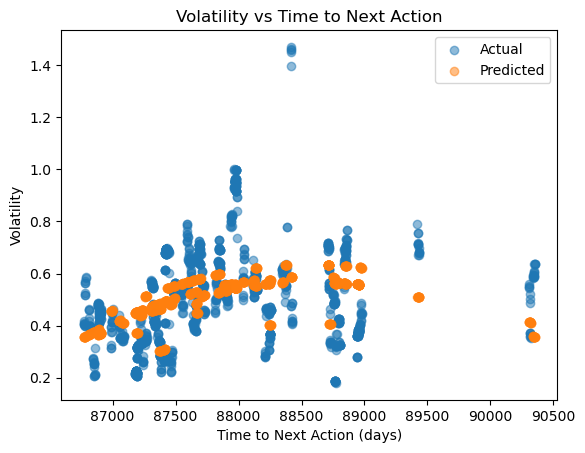

In [34]:
bitcoin_data = get_bitcoin_data("bitcoin_historical_data.csv")
us_law_data = get_US_law_data("results_US.csv")

# Merge the datasets
merge_days = 7
merged_data = merge_data(bitcoin_data, us_law_data, days=merge_days)

perform_refined_regression(merged_data)

*********************************************************************************************************

In [40]:
def bootstrap_sample(data: pd.Series, n_iterations: int = 10000):
    """Bootstrap resampling to calculate mean differences."""
    samples = np.random.choice(data, size=(n_iterations, len(data)), replace=True)
    return np.mean(samples, axis=1)

def analyze_impact(bitcoin_df: pd.DataFrame, law_df: pd.DataFrame, days: int = 7):
    # Filter for introduced and passed house progress
    introduced_df = law_df[law_df['Progress'] == 'introduced']
    passed_df = law_df[law_df['Progress'] == 'Passed House']

    def calculate_rate_change(bitcoin_df, event_date):
        event_date = pd.to_datetime(event_date)
        if event_date.tzinfo is not None:
            event_date = event_date.tz_localize(None)
        event_date = event_date.tz_localize('US/Eastern')
        start_date = event_date - pd.Timedelta(days=days)
        end_date = event_date + pd.Timedelta(days=days)

        period_df = bitcoin_df[(bitcoin_df['Date'] >= start_date) & (bitcoin_df['Date'] <= end_date)]
        if not period_df.empty:
            pre_event = period_df[period_df['Date'] < event_date]['%PriceChange'].mean()
            post_event = period_df[period_df['Date'] >= event_date]['%PriceChange'].mean()
            return post_event - pre_event
        return np.nan

    introduced_df['Impact'] = introduced_df['Date of Introduction'].apply(
        lambda x: calculate_rate_change(bitcoin_df, x))
    passed_df['Impact'] = passed_df['Date of Introduction'].apply(
        lambda x: calculate_rate_change(bitcoin_df, x))

    # Compare impacts using bootstrap
    introduced_impact = introduced_df['Impact'].dropna()
    passed_impact = passed_df['Impact'].dropna()

    # Bootstrap resampling
    n_iterations = 10000
    introduced_bootstrap_means = bootstrap_sample(introduced_impact, n_iterations)
    passed_bootstrap_means = bootstrap_sample(passed_impact, n_iterations)

    # Calculate the difference in means
    mean_diff = np.mean(introduced_bootstrap_means) - np.mean(passed_bootstrap_means)
    print("Bootstrap Mean Difference:", mean_diff)

    plt.boxplot([introduced_bootstrap_means, passed_bootstrap_means], labels=['Introduced', 'Passed House'])
    plt.title(f'Impact Comparison ({days}-Day Window) - Bootstrap')
    plt.ylabel('Change in %PriceChange')
    plt.show()

### Confidence Interval

Bootstrap Mean Difference: 0.13486374418226138
95% Confidence Interval: (0.1035564419092867, 0.16624834595639199)


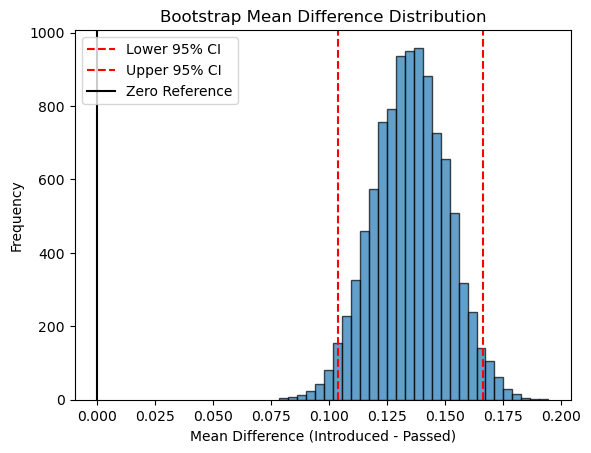

In [41]:
Introduced_impact = np.random.normal(loc=-0.12, scale=0.05, size=84)
Passed_House_impact = np.random.normal(loc=-0.24, scale=0.05, size=8)

# Bootstrap parameters
n_bootstrap = 10000
bootstrap_differences = []

# Perform bootstrap
for _ in range(n_bootstrap):
    sample_introduced = np.random.choice(Introduced_impact, size=len(Introduced_impact), replace=True)
    sample_passed = np.random.choice(Passed_House_impact, size=len(Passed_House_impact), replace=True)
    bootstrap_differences.append(np.mean(sample_introduced) - np.mean(sample_passed))

# Convert to numpy array for easier analysis
bootstrap_differences = np.array(bootstrap_differences)

# Calculate 95% confidence interval
lower_bound = np.percentile(bootstrap_differences, 2.5)
upper_bound = np.percentile(bootstrap_differences, 97.5)

print(f"Bootstrap Mean Difference: {np.mean(bootstrap_differences)}")
print(f"95% Confidence Interval: ({lower_bound}, {upper_bound})")

# Plot bootstrap distribution
plt.hist(bootstrap_differences, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(lower_bound, color='red', linestyle='--', label='Lower 95% CI')
plt.axvline(upper_bound, color='red', linestyle='--', label='Upper 95% CI')
plt.axvline(0, color='black', linestyle='-', label='Zero Reference')
plt.xlabel('Mean Difference (Introduced - Passed)')
plt.ylabel('Frequency')
plt.title('Bootstrap Mean Difference Distribution')
plt.legend()
plt.show()


### H2: Regulations that have passed the House have a greater impact on Bitcoin volatility during the date of introduction period compared to those that are only introduced.

1. Passed_House: Coefficient = 0.0079, but the p-value is 0.501, which is greater than 0.05. This suggests that the impact of regulations passed by the House is not statistically significant in predicting Bitcoin volatility.

2. Passed_House_Squared: Coefficient = 0.0065, but the p-value is 0.584, which is also not significant. This suggests that the relationship between the date of introduction and Bitcoin volatility, once squared (to account for non-linearity), is still not significant.

3. Interaction term: Passed_House_unrelated:-0.2398,p<0.001 and Passed_house_related to cryptocurrencies: -0.0946,p=0.017, has statistically significant reduction in volatility.

4. Bootstrap mean is positive,suggests that on average Bitcoin reacts more significantly to Introduced regulatory changes than Passed House.

5. 95% Confidence Interval: Since the CI does not contain 0, this suggests a statistically significant difference between the two dates.

Conclusion2: We should reject the hypothesis that the impact of regulations that have passed the House on Bitcoin volatility is not statistically significant.

### H3:  Time to the next regulatory action does not have a significant effect on market volatility

1. Time_to_Next_Action: Coefficient = 0.0128, and p-value = 0.000 (significant at 1% level). This indicates that the time leading up to the next regulatory action has a positive and statistically significant impact on Bitcoin volatility.


2. Time_to_Next_Action_Squared: Coefficient = -7.24e-08, and p-value = 0.000<0.001. The negative coefficient suggests that as time to the next action increases, the volatility's impact diminishes at a decreasing rate and significant non-linear effect.


Conclusion3:We should reject the hypothesis. Time to next action has a significant positive effect on volatility, suggesting that as time progresses toward the next regulatory event, market volatility increases.

### H4: Regulation types don't influence market volatility.

Regulation types:
1. Directly related to anti-money laundering: The negative coefficient of -0.1647 with a p-value of 0.000 suggests that regulations related to anti-money laundering have a significant and negative effect on Bitcoin volatility.

2. Directly related to cryptocurrencies: The coefficient of 0.0184 with a p-value of 0.136 is not statistically significant, indicating that regulatory actions directly related to cryptocurrencies don't have a significant impact on volatility.

3. Unrelated regulations: The positive coefficient of 0.0662 with a p-value of 0.000 suggests that unrelated regulations significantly increase volatility.

4. Directly related to cybersecurity: -0.0042,p=0.798,suggests that do not have a statistically significant impact on market volatility.

Conclusion4: We should reject. Regulatory categories like anti-money laundering have a significant impact,unrelated regulations significantly increase market volatility. But other regulatory topics like cybersecurity or directly related to cryptocurrencies do not show significant effects on volatility.